# Hydro: solutionnaire



## Charger vos données

### Import

In [3]:
import pandas as pd

### Charger

In [5]:
url = 'https://raw.githubusercontent.com/mtlpy/mtlpy-exercises/main/hydro/data/jours/0123456789_jour_2018-06-19_au_2018-08-20.csv'
data = pd.read_csv(url, encoding='latin-1', sep=';')
print(len(data))

63


## Explorer et préparer les données

### Vue d'ensemble

In [ ]:
# volumétrie des colonnes et rangées et
# aperçu des types et valeurs des données
data

In [ ]:
# nom des colonnes
data.columns

```
c = data['Contrat']
c.
```

### Renommer les colonnes

In [ ]:
columns = {
    'Contrat': 'contrat',
    'Tarif': 'tarif',
    'Date': 'date',
    'kWh': 'kwh',
    'Code de consommation': 'consommation',
    'Température moyenne (°C)': 'temp',
    'Code de température': 'temp_code',
}
data = data.rename(columns=columns)
data

### Vérifier les valeurs

In [ ]:
# numéro de contrat: unique, sans surprise, donc inutile
data['contrat'].unique()

In [ ]:
# catégorie de tarification: unique dans ce fichier, inutile si on ne s'intéresse pas au prix
data['tarif'].unique()

In [ ]:
# code de consommation: utile si on s'intéresse au type de consommation ou au prix?
data['consommation'].unique()   # R, M

In [ ]:
# pour connaître le nombre d'occurence de chaque valeur
data['consommation'].value_counts()

In [ ]:
# code de température: unique, utile si on s'intéresse à tarification et tarification fonction du code de température?
data['temp_code'].unique()

In [ ]:
# les dates ont toutes le format ISO ('yyyy-mm-dd'): parfait, mais sont des strings
print(type(data.loc[0, 'date']))
data['date'].unique()

In [ ]:
# température: toutes des entiers, OK
print(type(data.loc[0, 'temp']))
data['temp'].unique()

In [ ]:
# kwh: OK toutes des données vraisemblables mais sont des floats formattés string en `fr-ca` (séparateur décimales = ',' et non '.')
print(type(data.loc[0, 'kwh']))
data['kwh'].unique()

### Transformez les valeurs

#### kwh

In [ ]:
# les kwh en float

# fonction de conversion
def str2float(value):
    new_value = value
    if type(value) == str:
        # change , into .
        new_value = value.replace(',', '.')
        # cast to float
        new_value = float(new_value)
    return new_value

# convert kwh values
#data.loc[:, 'kwh'] = data['kwh'].apply(str2float)
data['kwh'] = data['kwh'].apply(str2float)

# preuve
print(type(data.loc[0, 'kwh']))
data['kwh'].unique()

In [ ]:
data

#### date

In [ ]:
# dates en... dates

# fonction de conversion
def str2date(value):
    new_value = value
    if type(value) == str:
        # via builtin converters de pandas...
        new_value = pd.to_datetime(value).date()
    return new_value

# convert date values
# data.loc[:, 'date'] = data['date'].apply(str2date)
data['date'] = data['date'].apply(str2date)

# preuve
print(type(data.loc[0, 'date']))
data['date'].unique()

### Modifier l'index

In [ ]:
data.set_index('date', inplace=True)
data

In [ ]:
# import datetime as dt
# data.loc[dt.datetime.strptime('2018-08-20', '%Y-%m-%d').date()]
data.loc['2018-08-20']

## Analyser les données

### Conserver que les colonnes utiles

In [ ]:
mask = ['kwh', 'temp']
data = data[mask]
data

### Statistiques

Les stats de base: min, max, moyenne...

In [ ]:
data.describe()

## Visualiser les données

In [ ]:
data.plot()

## Fusionner les données

### Test de fusion

In [ ]:
# charger un 2e fichier
url2 = 'https://raw.githubusercontent.com/mtlpy/mtlpy-exercises/main/hydro/data/jours/0123456789_jour_2019-06-26_au_2019-08-23.csv'
data2 = pd.read_csv(url2, encoding='latin-1', sep=';')

# le transformer comme le 1er
data2 = data2.rename(columns=columns)
data2.loc[:, 'kwh'] = data2['kwh'].apply(str2float)
data2.loc[:, 'date'] = data2['date'].apply(str2date)
data2.set_index('date', inplace=True)
data2 = data2[['kwh', 'temp']]

In [ ]:
# vérifier les données du 2e fichier
data2

In [ ]:
# vérifier le graphe du 2e fichier
data2.plot()

In [ ]:
# fusion à partir de la meilleure approche identifiée dans la doc
# fusion basée sur conservation des index

frames = [data, data2]
data_test = pd.concat(frames)

# vérifier la volumétrie
len(data_test) == len(data) + len(data2)

In [ ]:
# vérifier graphe final (1er et 2e fichiers ensembles)
data_test.plot()

On a la bonne approche pour fusionner.
* des trous dans les dates des données (voir les noms de fichier pour preuve) expliquent l'extrapolation (droite)

Reste à réorganiser notre code dans des fonctions pour appliquer plus facilement les transformations qu'on veut faire sur chaque fichier.

### Fusion en masse

Fonctions de conversion: même code que plus haut, remis ici par commodité.

In [ ]:
import pandas as pd

# fonction de conversion
def str2float(value):
    new_value = value
    if type(value) == str:
        # change , into .
        new_value = value.replace(',', '.')
        # cast to float
        new_value = float(new_value)
    return new_value

# fonction de conversion
def str2date(value):
    new_value = value
    if type(value) == str:
        # via builtin converters de pandas...
        new_value = pd.to_datetime(value).date()
    return new_value

Nouvelle fonction qui centrlise les transformations sur un fichier.

In [ ]:
def load_jour(file_path, alt_encoding='latin-1', sep=';'):
    """
    Traiter un fichier de données journalières provenant de Hydro-Québec.
    """

    # load
    try:
        # UTF-8
        data = pd.read_csv(file_path, sep=sep)
    except UnicodeDecodeError:
        # alt_encoding
        data = pd.read_csv(file_path, encoding=alt_encoding, sep=sep)

    # rename columns
    columns = {
        'Contrat': 'contrat',
        'Tarif': 'tarif',
        'Date': 'date',
        'kWh': 'kwh',
        'Code de consommation': 'consommation',
        'Température moyenne (°C)': 'temp',
        'Code de température': 'temp_code',
    }
    data = data.rename(columns=columns)

    # convert kwh values
    data.loc[:, 'kwh'] = data['kwh'].apply(str2float)

    # convert date values
    data.loc[:, 'date'] = data['date'].apply(str2date)

    # keep useful columns
    data = data[['date', 'kwh', 'temp']]

    # new index for rows
    data.set_index('date', inplace=True)

    return data

Déclaration des fichiers à traiter.

Avec des fichiers CSV en local sur votre machine, vous pourriez obtenir tous les _paths_ des fichiers avec cette commande
```
import glob

file_paths = glob.glob('data/jours/*.csv')
file_paths.sort()
```

In [ ]:
# https://github.com/mtlpy/mtlpy-exercises/tree/main/hydro/data/jours
main_url = 'https://raw.githubusercontent.com/mtlpy/mtlpy-exercises/main/hydro/data/jours'

file_urls = [
    # seulement jours continus pour éviter trous dans graph
    # f'{main_url}/0123456789_jour_2018-06-19_au_2018-08-20.csv',
    f'{main_url}/0123456789_jour_2019-04-25_au_2019-06-25.csv',
    f'{main_url}/0123456789_jour_2019-06-26_au_2019-08-23.csv',
    f'{main_url}/0123456789_jour_2019-08-24_au_2019-10-24.csv',
    f'{main_url}/0123456789_jour_2019-10-25_au_2019-12-20.csv',
    f'{main_url}/0123456789_jour_2019-12-21_au_2020-02-25.csv',
    f'{main_url}/0123456789_jour_2020-02-26_au_2020-04-27.csv',
    f'{main_url}/0123456789_jour_2020-02-26_au_2020-04-27.csv',
    f'{main_url}/0123456789_jour_2020-04-28_au_2020-06-25.csv',
    # f'{main_url}/0123456789_jour_2020-06-26_au_2020-07-05.csv',
    f'{main_url}/0123456789_jour_2020-06-26_au_2020-08-25.csv',
    f'{main_url}/0123456789_jour_2020-08-26_au_2020-10-26.csv',
    f'{main_url}/0123456789_jour_2020-10-27_au_2020-12-23.csv',
    f'{main_url}/0123456789_jour_2020-12-24_au_2021-02-23.csv',
    f'{main_url}/0123456789_jour_2021-02-24_au_2021-04-27.csv',
    # f'{main_url}/0123456789_jour_2021-04-28_au_2021-05-09.csv',
    f'{main_url}/0123456789_jour_2021-04-28_au_2021-06-25.csv',
]

In [ ]:
# load csv files as dataframes
frames = []
for file_url in file_urls:
    data = load_jour(file_url)
    frames.append(data)

In [ ]:
# merge in one dataset
jours = pd.concat(frames)
jours.sort_index(inplace=True)

In [ ]:
# vérifier le merge
print(len(jours))
jours.describe()

In [ ]:
# visualiser tout le jeu de données

jours.plot()

In [ ]:
jours.corr?

## Conclusion

On voit clairement une corrélation globale entre la consommation électrique quotidienne et la température quotidienne.

# Cheat sheet

## Un seul fichier

<class 'str'>


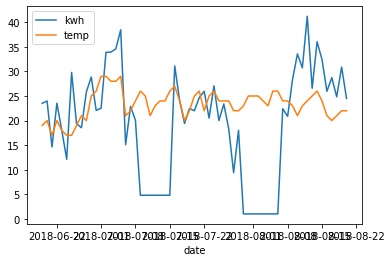

In [ ]:
import pandas as pd

# data import
url = 'https://raw.githubusercontent.com/mtlpy/mtlpy-exercises/main/hydro/data/jours/0123456789_jour_2018-06-19_au_2018-08-20.csv'
data = pd.read_csv(url, encoding='latin-1', sep=';')

# data exploration
data
data.columns
data['Contrat'].unique()
data['Code de consommation'].value_counts()
print(type(data.loc[0, 'Date']))

# data preparation

## rename
columns = {
    'Contrat': 'contrat',
    'Tarif': 'tarif',
    'Date': 'date',
    'kWh': 'kwh',
    'Code de consommation': 'consommation',
    'Température moyenne (°C)': 'temp',
    'Code de température': 'temp_code',
}
data = data.rename(columns=columns)

## convert kwh
def str2float(value):
    new_value = value
    if type(value) == str:
        # change , into .
        new_value = value.replace(',', '.')
        # cast to float
        new_value = float(new_value)
    return new_value

#data.loc[:, 'kwh'] = data['kwh'].apply(str2float)
data['kwh'] = data['kwh'].apply(str2float)

# convert date
def str2date(value):
    new_value = value
    if type(value) == str:
        # via builtin converters de pandas...
        new_value = pd.to_datetime(value).date()
    return new_value

# data.loc[:, 'date'] = data['date'].apply(str2date)
data['date'] = data['date'].apply(str2date)

## modify index
data.set_index('date', inplace=True)

# data analysis
mask = ['kwh', 'temp']
data = data[mask]
data.describe()

# data visualization
data.plot()

## Plusieurs fichiers

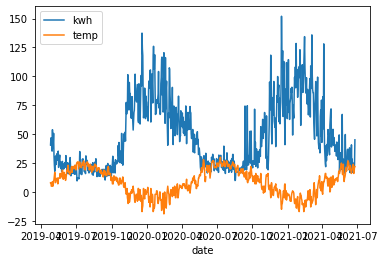

In [ ]:
import pandas as pd

# data import

def load_jour(file_path, alt_encoding='latin-1', sep=';'):
    """
    Traiter un fichier de données journalières provenant de Hydro-Québec.
    """

    # load
    try:
        # UTF-8
        data = pd.read_csv(file_path, sep=sep)
    except UnicodeDecodeError:
        # alt_encoding
        data = pd.read_csv(file_path, encoding=alt_encoding, sep=sep)

    # rename columns
    columns = {
        'Contrat': 'contrat',
        'Tarif': 'tarif',
        'Date': 'date',
        'kWh': 'kwh',
        'Code de consommation': 'consommation',
        'Température moyenne (°C)': 'temp',
        'Code de température': 'temp_code',
    }
    data = data.rename(columns=columns)

    # convert kwh values
    data.loc[:, 'kwh'] = data['kwh'].apply(str2float)

    # convert date values
    data.loc[:, 'date'] = data['date'].apply(str2date)

    # keep useful columns
    data = data[['date', 'kwh', 'temp']]

    # new index for rows
    data.set_index('date', inplace=True)

    return data

# https://github.com/mtlpy/mtlpy-exercises/tree/main/hydro/data/jours
main_url = 'https://raw.githubusercontent.com/mtlpy/mtlpy-exercises/main/hydro/data/jours'

file_urls = [
    # seulement jours continus pour éviter trous dans graph
    # f'{main_url}/0123456789_jour_2018-06-19_au_2018-08-20.csv',
    f'{main_url}/0123456789_jour_2019-04-25_au_2019-06-25.csv',
    f'{main_url}/0123456789_jour_2019-06-26_au_2019-08-23.csv',
    f'{main_url}/0123456789_jour_2019-08-24_au_2019-10-24.csv',
    f'{main_url}/0123456789_jour_2019-10-25_au_2019-12-20.csv',
    f'{main_url}/0123456789_jour_2019-12-21_au_2020-02-25.csv',
    f'{main_url}/0123456789_jour_2020-02-26_au_2020-04-27.csv',
    f'{main_url}/0123456789_jour_2020-02-26_au_2020-04-27.csv',
    f'{main_url}/0123456789_jour_2020-04-28_au_2020-06-25.csv',
    # f'{main_url}/0123456789_jour_2020-06-26_au_2020-07-05.csv',
    f'{main_url}/0123456789_jour_2020-06-26_au_2020-08-25.csv',
    f'{main_url}/0123456789_jour_2020-08-26_au_2020-10-26.csv',
    f'{main_url}/0123456789_jour_2020-10-27_au_2020-12-23.csv',
    f'{main_url}/0123456789_jour_2020-12-24_au_2021-02-23.csv',
    f'{main_url}/0123456789_jour_2021-02-24_au_2021-04-27.csv',
    # f'{main_url}/0123456789_jour_2021-04-28_au_2021-05-09.csv',
    f'{main_url}/0123456789_jour_2021-04-28_au_2021-06-25.csv',
]

## load csv files as dataframes
frames = []
for file_url in file_urls:
    data = load_jour(file_url)
    frames.append(data)

## merge in one dataset
jours = pd.concat(frames)
jours.sort_index(inplace=True)

# data visualization
jours.plot()

# Licence

Copyright 2021 Montréal-Python

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
